In [86]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

seed = 667

In [87]:
# ignore convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning) 
warnings.simplefilter('ignore', RuntimeWarning) 
warnings.simplefilter('ignore', UserWarning) 

In [88]:
df = pd.read_csv('dementia.tsv', sep='\t')

In [89]:
df = df.drop(columns=['Subject ID'])

In [90]:
df

,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,Demented,Group_num,CDR_int
0,Nondemented,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0,0,0
1,Nondemented,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0,0,0
2,Nondemented,1,0,0,88,18,3.0,28.0,0.0,1215,0.710,0,0,0
3,Nondemented,2,538,0,90,18,3.0,27.0,0.0,1200,0.718,0,0,0
4,Nondemented,1,0,1,80,12,4.0,28.0,0.0,1689,0.712,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,Demented,2,842,1,82,16,1.0,28.0,0.5,1693,0.694,1,1,1
350,Demented,3,2297,1,86,16,1.0,26.0,0.5,1688,0.675,1,1,1
351,Nondemented,1,0,0,61,13,2.0,30.0,0.0,1319,0.801,0,0,0
352,Nondemented,2,763,0,63,13,2.0,30.0,0.0,1327,0.796,0,0,0


In [91]:
covariates = ['Visit', 'Age', 'Sex', 'EDUC', 'SES', 'eTIV', 'nWBV', 'MMSE', 'MR Delay']

In [92]:
# Split data into train and test sets
np.random.seed(667)
train_mask = np.random.rand(df.shape[0]) > .2

test_df = df[~train_mask]
train_df = df[train_mask]

print('Training data:')
print('total observations: ' + str(train_df.shape[0]))
print(df.head())
print('Testing data:')
print('total observations: ' + str(test_df.shape[0]))
print(test_df.head())

Training data:
total observations: 289
         Group  Visit  MR Delay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  Nondemented      1         0    1   87    14  2.0  27.0  0.0  1987  0.696   
1  Nondemented      2       457    1   88    14  2.0  30.0  0.0  2004  0.681   
2  Nondemented      1         0    0   88    18  3.0  28.0  0.0  1215  0.710   
3  Nondemented      2       538    0   90    18  3.0  27.0  0.0  1200  0.718   
4  Nondemented      1         0    1   80    12  4.0  28.0  0.0  1689  0.712   

   Demented  Group_num  CDR_int  
0         0          0        0  
1         0          0        0  
2         0          0        0  
3         0          0        0  
4         0          0        0  
Testing data:
total observations: 65
          Group  Visit  MR Delay  Sex  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
1   Nondemented      2       457    1   88    14  2.0  30.0  0.0  2004  0.681   
10     Demented      2       576    1   69    12  2.0  24.0  0.5  1480  0.791

In [93]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [94]:
# For brute-force search, we need to get all sublists from the list of columns except the empty sublist
def sublists(columns):
    sublists = []
    
    for i in range(0, len(columns)+1):
        temp = [list(x) for x in combinations(columns, i)]
        if len(temp)>0:
            sublists.extend(temp)
            
    sublists.remove([])
            
    return sublists 

# Here we create a brute-force search function which runs 5-fold cross-validation for each sublist
# We can define which objective function to use for optimization
def brute_search(model, data, response, covariates, obj_fn):
    resp = data[response]
    preds = data[covariates]
    search_space = sublists(preds.columns.tolist())
    
    bestobj = -np.inf
    best_cols = None
    
    for cols in search_space:
        objs = []
        for train_index, test_index in skf.split(preds[cols], resp):
            res = model().fit(data.iloc[train_index][cols], resp.iloc[train_index])
#             tmpobj = res.llf - penalty*len(cols)
            test_preds = res.predict(data.iloc[test_index][cols])
            objs.append(obj_fn(resp.iloc[test_index], test_preds))
        tmpobj = sum(objs) / len(objs)
#         print('{0}: {1}'.format(cols, tmpobj))
#         print(objs)
        if tmpobj > bestobj:
            bestobj = tmpobj
            best_cols = cols
            
    res = model().fit(data[best_cols], resp)
    return bestobj, best_cols, res

# `Demented` response
## Random Forests

In [95]:
def demented_obj_fn(gt, preds):
    return accuracy_score(gt, [0 if i < 0.5 else 1 for i in preds])

In [96]:
model = RandomForestClassifier(n_jobs=-1)

In [97]:
model.fit(train_df[covariates], train_df.Demented)

RandomForestClassifier(n_jobs=-1)

In [98]:
preds = model.predict(test_df[covariates])

In [99]:
roc_auc_score(test_df.Demented, preds)

0.8572124756335282

In [100]:
accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])

0.8769230769230769

In [101]:
covariates

['Visit', 'Age', 'Sex', 'EDUC', 'SES', 'eTIV', 'nWBV', 'MMSE', 'MR Delay']

In [102]:
model.feature_importances_

array([0.02161962, 0.10511576, 0.05325218, 0.07143243, 0.04456011,
       0.12686044, 0.16819042, 0.33779166, 0.07117737])

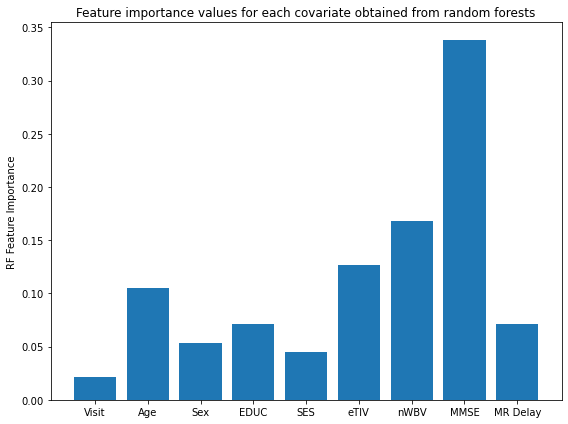

In [111]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(covariates, model.feature_importances_)
plt.ylabel('RF Feature Importance')
plt.title('Feature importance values for each covariate obtained from random forests')

plt.tight_layout()
plt.savefig('figures/rf_feat_imp.png')

### Feature selection

In [74]:
print('Brute-force')
bf_obj, bf_cols, bf_res = brute_search(RandomForestClassifier, train_df[covariates + ['Demented']], 'Demented', covariates, demented_obj_fn)
preds = bf_res.predict(test_df[bf_cols])
print('auc: {0}:'.format(roc_auc_score(test_df.Demented, preds)))
print('acc: {0}:'.format(accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])))
print()

Brute-force
auc: 0.8308966861598439:
acc: 0.8461538461538461:



In [75]:
bf_cols

['Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'MMSE', 'MR Delay']

In [77]:
bf_res.feature_importances_

array([0.10812986, 0.08173101, 0.05863374, 0.14315138, 0.18708404,
       0.33448289, 0.08678709])

## SVC

In [18]:
model = SVC()

In [19]:
model.fit(train_df[covariates], train_df.Demented)

SVC()

In [20]:
preds = model.predict(test_df[covariates])

In [21]:
roc_auc_score(test_df.Demented, preds)

0.5

In [22]:
accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])

0.5846153846153846

In [23]:
print('Brute-force')
bf_obj, bf_cols, bf_res = brute_search(SVC, train_df[covariates + ['Demented']], 'Demented', covariates, demented_obj_fn)
preds = bf_res.predict(test_df[bf_cols])
print('auc: {0}:'.format(roc_auc_score(test_df.Demented, preds)))
print('acc: {0}:'.format(accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])))
print()

Brute-force
auc: 0.8518518518518519:
acc: 0.8769230769230769:



In [24]:
bf_cols

['MMSE']

# `Group` Response
## Random Forests

In [78]:
model = RandomForestClassifier(n_jobs=-1)

In [79]:
model.fit(train_df[covariates], train_df.Group_num)

RandomForestClassifier(n_jobs=-1)

In [80]:
preds = model.predict(test_df[covariates])

In [81]:
roc_auc_score(test_df.Demented, preds)

0.834307992202729

In [82]:
accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])

0.8615384615384616

In [83]:
accuracy_score(test_df.Group_num, preds)

0.8

### Model Selection

In [84]:
print('Brute-force')
bf_obj, bf_cols, bf_res = brute_search(RandomForestClassifier, train_df[covariates + ['Group_num']], 'Group_num', covariates, accuracy_score)
preds = bf_res.predict(test_df[bf_cols])
print('auc: {0}:'.format(roc_auc_score(test_df.Demented, preds)))
print('acc (converted): {0}:'.format(accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])))
print('acc (no convert): {0}:'.format(accuracy_score(test_df.Group_num, preds)))
print()

Brute-force
auc: 0.8606237816764134:
acc (converted): 0.8923076923076924:
acc (no convert): 0.8615384615384616:



In [32]:
bf_cols

['Age', 'EDUC', 'SES', 'eTIV', 'MMSE']

In [85]:
bf_res.feature_importances_

array([0.17254763, 0.05521469, 0.11584027, 0.08701568, 0.22196234,
       0.34741939])

## SVC

In [33]:
model = SVC()

In [34]:
model.fit(train_df[covariates], train_df.Group_num)

SVC()

In [35]:
preds = model.predict(test_df[covariates])

In [36]:
roc_auc_score(test_df.Demented, preds)

0.5

In [37]:
accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])

0.5846153846153846

In [38]:
accuracy_score(test_df.CDR_int, preds)

0.5846153846153846

In [39]:
print('Brute-force')
bf_obj, bf_cols, bf_res = brute_search(SVC, train_df[covariates + ['Group_num']], 'Group_num', covariates, accuracy_score)
preds = bf_res.predict(test_df[bf_cols])
print('auc: {0}:'.format(roc_auc_score(test_df.Demented, preds)))
print('acc (converted): {0}:'.format(accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])))
print('acc (no convert): {0}:'.format(accuracy_score(test_df.Group_num, preds)))
print()

Brute-force
auc: 0.8518518518518519:
acc (converted): 0.8769230769230769:
acc (no convert): 0.7846153846153846:



In [40]:
bf_cols

['MMSE']

# `CDR` Response
## Random Forests

In [41]:
model = RandomForestClassifier(n_jobs=-1)

In [42]:
model.fit(train_df[covariates], train_df.CDR_int)

RandomForestClassifier(n_jobs=-1)

In [43]:
preds = model.predict(test_df[covariates])

In [44]:
roc_auc_score(test_df.Demented, preds)

0.8703703703703703

In [45]:
accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])

0.8923076923076924

In [46]:
accuracy_score(test_df.CDR_int, preds)

0.8153846153846154

### Model Selection

In [47]:
print('Brute-force')
bf_obj, bf_cols, bf_res = brute_search(RandomForestClassifier, train_df[covariates + ['CDR_int']], 'CDR_int', covariates, accuracy_score)
preds = bf_res.predict(test_df[bf_cols])
print('auc: {0}:'.format(roc_auc_score(test_df.Demented, preds)))
print('acc (converted): {0}:'.format(accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])))
print('acc (no convert): {0}:'.format(accuracy_score(test_df.CDR_int, preds)))
print()

Brute-force
auc: 0.8411306042884991:
acc (converted): 0.8615384615384616:
acc (no convert): 0.7846153846153846:



In [48]:
bf_cols

['Visit', 'Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'MMSE']

## SVC

In [49]:
model = SVC()

In [50]:
model.fit(train_df[covariates], train_df.CDR_int)

SVC()

In [51]:
preds = model.predict(test_df[covariates])

In [52]:
roc_auc_score(test_df.Demented, preds)

0.5

In [53]:
accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])

0.5846153846153846

In [54]:
accuracy_score(test_df.CDR_int, preds)

0.5846153846153846

In [55]:
print('Brute-force')
bf_obj, bf_cols, bf_res = brute_search(SVC, train_df[covariates + ['CDR_int']], 'CDR_int', covariates, accuracy_score)
preds = bf_res.predict(test_df[bf_cols])
print('auc: {0}:'.format(roc_auc_score(test_df.Demented, preds)))
print('acc (converted): {0}:'.format(accuracy_score(test_df.Demented, [0 if i < 0.5 else 1 for i in preds])))
print('acc (no convert): {0}:'.format(accuracy_score(test_df.CDR_int, preds)))
print()

Brute-force
auc: 0.8333333333333333:
acc (converted): 0.8615384615384616:
acc (no convert): 0.7692307692307693:



In [56]:
bf_cols

['EDUC', 'MMSE']